In [73]:
import os
_FINAL_DFS_DIR = os.path.join('..', '..', 'final_dfs')

import sys
sys.path.append('..')


In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter
from scipy import stats
import pandas as pd
import numpy as np

In [121]:
dbf = os.path.join(_FINAL_DFS_DIR, 'results.parquet')
df = pd.read_parquet(dbf, engine='pyarrow')

mask = ((df['method_name'] != "BestSVR") &
        (df['method_name'] != "BestMLP") &
        (df['eeg_name'] == "EEG_Raw") & 
        (df['test_name'] == "random"))

df = df[mask]
df['method_name'].unique()

array(['LinearRegression', 'Shuffle_LinearRegression',
       'DummyScoring_Mean', 'SVR', 'MLP'], dtype=object)

In [122]:
df.keys()

Index(['method_name', 'training_size', 'eeg_name', 'test_name', 'fit_time',
       'source_id', 'raw_scores', 'shuffled_scores', 'target_raw_score',
       'target_shuffled_score', 'scores', 'true_distances', 'raw_scores_std',
       'shuffled_scores_std', 'scores_std', 'euclidean_at_top_rank',
       'pearsonr_statistic', 'pearsonr_pvalue', 'spearmanr_statistic',
       'spearmanr_pvalue', 'target_rank', 'top_1_accuracy',
       'min_euclidean_top_1', 'top_3_accuracy', 'min_euclidean_top_3',
       'top_5_accuracy', 'min_euclidean_top_5', 'top_10_accuracy',
       'min_euclidean_top_10', 'range_to_noise_ratio', 'snr_classic',
       'snr_power', 'signal_to_uncertainty_ratio', 'rmse_true_vs_estimated'],
      dtype='object')

<Axes: xlabel='training_size', ylabel='top_3_accuracy'>

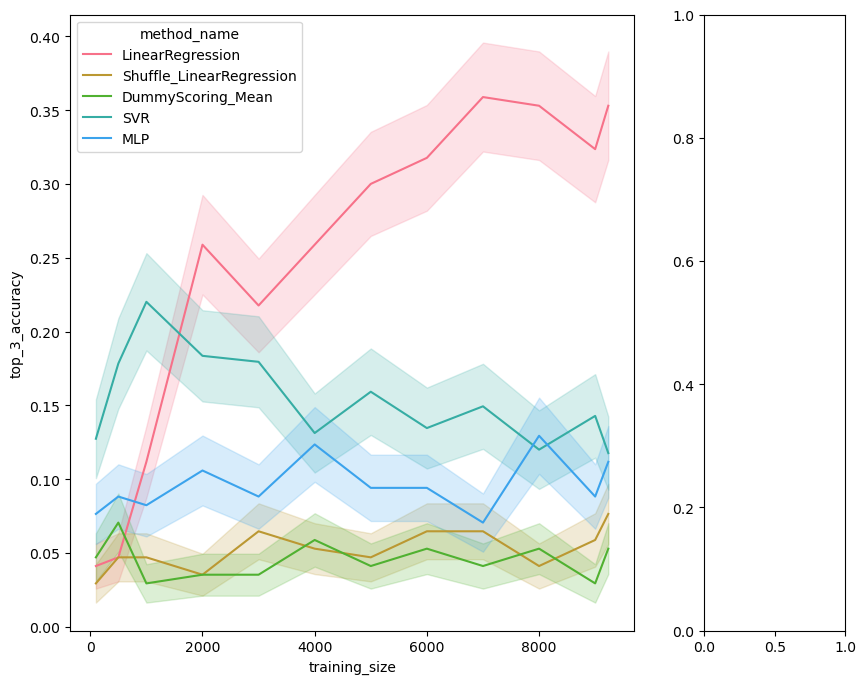

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               figsize=(10, 8), 
                               gridspec_kw={'width_ratios': [4, 1]})

sns.lineplot(data=df, 
             x='training_size', 
             y='top_3_accuracy', 
             hue='method_name', 
             errorbar=('se', 1),
             ax=ax1)

In [124]:
import math

def prob_n1_selected(N, K):
    """True probability that N1 is selected in top-K from N items"""
    return 1 - (1 - 1/N)**K

def sampling_uncertainty(p, n_samples):
    """
    Standard deviation of probability estimate from finite samples
    Using standard error of proportion: sqrt(p(1-p)/n)
    """
    variance = p * (1 - p) / n_samples
    std_error = math.sqrt(variance)
    return std_error

def confidence_interval(p, std_error, z_score=1.96):
    """Calculate confidence interval (default 95%)"""
    margin = z_score * std_error
    return p - margin, p + margin

N = 60
k_values = [1, 3, 5, 10]
n_samples = 170

print(f"Top-K Accuracy Estimation with N = {N}, n_samples = {n_samples}")
print("=" * 70)
print(f"{'K':<3} {'True P(N1)':<12} {'Std Error':<12} {'95% CI Lower':<12} {'95% CI Upper':<12}")
print("-" * 70)

for k in k_values:
    # True probability (theoretical)
    true_prob = prob_n1_selected(N, k)
    
    # Standard error of the probability estimate
    std_error = sampling_uncertainty(true_prob, n_samples)
    
    # 95% confidence interval
    ci_lower, ci_upper = confidence_interval(true_prob, std_error)
    
    print(f"{k:<3} {true_prob:<12.6f} {std_error:<12.6f} {ci_lower:<12.6f} {ci_upper:<12.6f}")

print(f"\nInterpretation:")
print(f"- 'True P(N1)': Theoretical probability of N1 being in top-K")
print(f"- 'Std Error': Standard deviation of your probability estimate with {n_samples} samples")
print(f"- '95% CI': Your estimated probability will likely fall in this range")
print(f"- Smaller std error = more precise estimate")

print(f"\nExample: For K=5, your estimate will be true_prob ± {sampling_uncertainty(prob_n1_selected(N, 5), n_samples):.4f} with 95% confidence")

Top-K Accuracy Estimation with N = 60, n_samples = 170
K   True P(N1)   Std Error    95% CI Lower 95% CI Upper
----------------------------------------------------------------------
1   0.016667     0.009819     -0.002578    0.035911    
3   0.049171     0.016584     0.016667     0.081675    
5   0.080601     0.020878     0.039680     0.121523    
10  0.154706     0.027735     0.100345     0.209068    

Interpretation:
- 'True P(N1)': Theoretical probability of N1 being in top-K
- 'Std Error': Standard deviation of your probability estimate with 170 samples
- '95% CI': Your estimated probability will likely fall in this range
- Smaller std error = more precise estimate

Example: For K=5, your estimate will be true_prob ± 0.0209 with 95% confidence


In [125]:
import numpy as np
import pandas as pd

# Get all unique method names
unique_methods = ['LinearRegression', 'Shuffle_LinearRegression', 'DummyScoring_Mean', 'MLP', 'SVR']

# Store results for all methods
all_results = {}

for method in unique_methods:
    # print(f"\n=== Results for {method} ===")
    
    # Filter data for current method and training size
    method_data = df[df['method_name'] == method]
    method_data = method_data[method_data['training_size'] == 9234]
    
    if method_data.shape[0] == 0:
        print(f"No data found for {method} with training_size 9234")
        continue
    
    method_results = {'method': method, 'num_samples': method_data.shape[0]}
    
    # Calculate top-k accuracy with both mean and std
    # print("Top-k Accuracy:")
    for k in [1, 3, 5, 10]:
        top_k_values = method_data[f'top_{k}_accuracy']
        top_k_avg = np.round(np.mean(top_k_values), 3)
        top_k_std = np.round(np.std(top_k_values), 3)
        # print(f'  Top-{k} accuracy - Avg: {top_k_avg:.3f}, Std: {top_k_std:.3f}')
        method_results[f'top_{k}_accuracy_avg'] = top_k_avg
        method_results[f'top_{k}_accuracy_std'] = top_k_std
    
    # Calculate euclidean distance at top rank (should match top_1_min_euclidean)
    euclidean_at_top_values = method_data['euclidean_at_top_rank']
    euclidean_at_top_avg = np.round(np.mean(euclidean_at_top_values), 3)
    euclidean_at_top_std = np.round(np.std(euclidean_at_top_values), 3)
    # print(f"  Euclidean at top rank - Avg: {euclidean_at_top_avg:.2f}, Std: {euclidean_at_top_std:.2f}")
    method_results['euclidean_at_top_rank_avg'] = euclidean_at_top_avg
    method_results['euclidean_at_top_rank_std'] = euclidean_at_top_std
    
    # Calculate min euclidean distance stats (already precomputed)
    # print("Min Euclidean Distance in Top-k:")
    for k in [1, 3, 5, 10]:
        values = method_data[f'min_euclidean_top_{k}']
        avg = np.round(np.mean(values), 3)
        std = np.round(np.std(values), 3)
        # print(f'  Top-{k} min euclidean - Avg: {avg:.2f}, Std: {std:.2f}')
        method_results[f'top_{k}_min_euclidean_avg'] = avg
        method_results[f'top_{k}_min_euclidean_std'] = std
        
        # Verify that top_1_min_euclidean matches euclidean_at_top_rank
        if k == 1:
            # print(f"  Verification: euclidean_at_top_rank avg = {euclidean_at_top_avg:.4f}, top_1_min_euclidean avg = {avg:.4f}")
            if not np.allclose(euclidean_at_top_values, values, rtol=1e-10):
                print(f"  WARNING: euclidean_at_top_rank and top_1_min_euclidean don't match for {method}!")
    
    # Store results for this method
    all_results[method] = method_results

In [126]:
import numpy as np
import pandas as pd
import math

def proportion_std_error(p, n):
    """Standard error of proportion estimate"""
    return math.sqrt(p * (1 - p) / n)

# Define parameters
training_size = 9234
unique_methods = ['LinearRegression', 'Shuffle_LinearRegression', 'DummyScoring_Mean', 'MLP', 'SVR']

# Store results for all methods
all_results = {}

for method in unique_methods:
    # Filter data for current method and training size
    method_data = df[(df['method_name'] == method) & (df['training_size'] == training_size)]
    
    print(method_data.shape)
    if method_data.shape[0] == 0:
        print(f"No data found for {method} with training_size {training_size}")
        continue
    
    method_results = {'method': method, 'num_samples': method_data.shape[0]}
    n_samples = method_data.shape[0]  # This is your actual sample size
    
    # Calculate top-k accuracy stats
    for k in [1, 3, 5, 10]:
        values = method_data[f'top_{k}_accuracy']
        avg_accuracy = np.mean(values)
        # Use standard error of proportion instead of sample std
        std_error = proportion_std_error(avg_accuracy, n_samples)
        
        method_results[f'top_{k}_accuracy_avg'] = np.round(avg_accuracy, 3)
        method_results[f'top_{k}_accuracy_std'] = np.round(std_error, 3)
    
    # Calculate euclidean distance at top rank (keep sample std)
    euclidean_values = method_data['euclidean_at_top_rank']
    method_results['euclidean_at_top_rank_avg'] = np.round(np.mean(euclidean_values), 3)
    method_results['euclidean_at_top_rank_std'] = np.round(np.std(euclidean_values), 3)
    
    # Calculate min euclidean distance stats (keep sample std)
    for k in [1, 3, 5, 10]:
        values = method_data[f'min_euclidean_top_{k}']
        method_results[f'top_{k}_min_euclidean_avg'] = np.round(np.mean(values), 3)
        method_results[f'top_{k}_min_euclidean_std'] = np.round(np.std(values), 3)
    
    # Store results for this method
    all_results[method] = method_results

# Optional: Convert to DataFrame for easier viewing
results_df = pd.DataFrame(all_results).T

(170, 34)
(170, 34)
(170, 34)
(170, 34)
(170, 34)


In [127]:
from IPython.display import display, Markdown

# Create a nicely formatted markdown table for display in Jupyter
table_md = "\n| Model | Top-1 Acc | Top-3 Acc | Top-5 Acc | Top-10 Acc | Top-1 Min Dist | Top-3 Min Dist | Top-5 Min Dist | Top-10 Min Dist |\n"
table_md += "|-------|-----------|-----------|-----------|------------|----------------|----------------|----------------|------------------|\n"

for method, results in all_results.items():
    row = f"| {method}"
    
    # Add top-k accuracies with std
    for k in [1, 3, 5, 10]:
        acc_avg = results[f'top_{k}_accuracy_avg']
        acc_std = results[f'top_{k}_accuracy_std']
        row += f" | {acc_avg:.3f} ± {acc_std:.3f}"
    
    # Add top-k min euclidean distances (avg ± std)
    for k in [1, 3, 5, 10]:
        avg = results[f'top_{k}_min_euclidean_avg']
        std = results[f'top_{k}_min_euclidean_std']
        row += f" | {avg:.3f} ± {std:.3f}"
    
    row += " |\n"
    table_md += row

# Display as formatted markdown table in Jupyter
print("=== Summary Table ===")
display(Markdown(table_md))

=== Summary Table ===



| Model | Top-1 Acc | Top-3 Acc | Top-5 Acc | Top-10 Acc | Top-1 Min Dist | Top-3 Min Dist | Top-5 Min Dist | Top-10 Min Dist |
|-------|-----------|-----------|-----------|------------|----------------|----------------|----------------|------------------|
| LinearRegression | 0.171 ± 0.029 | 0.353 ± 0.037 | 0.565 ± 0.038 | 0.800 ± 0.031 | 2.898 ± 3.067 | 1.010 ± 1.312 | 0.524 ± 0.861 | 0.176 ± 0.450 |
| Shuffle_LinearRegression | 0.018 ± 0.010 | 0.076 ± 0.020 | 0.124 ± 0.025 | 0.265 ± 0.034 | 20.848 ± 13.436 | 10.035 ± 8.452 | 6.688 ± 6.197 | 2.980 ± 3.649 |
| DummyScoring_Mean | 0.024 ± 0.012 | 0.053 ± 0.017 | 0.112 ± 0.024 | 0.212 ± 0.031 | 21.355 ± 12.885 | 11.380 ± 8.544 | 7.037 ± 6.744 | 3.559 ± 4.028 |
| MLP | 0.029 ± 0.013 | 0.112 ± 0.024 | 0.194 ± 0.030 | 0.324 ± 0.036 | 12.112 ± 11.038 | 5.172 ± 5.672 | 2.930 ± 3.000 | 1.397 ± 1.736 |
| SVR | 0.035 ± 0.014 | 0.118 ± 0.025 | 0.206 ± 0.031 | 0.329 ± 0.036 | 6.771 ± 4.637 | 3.261 ± 2.688 | 2.153 ± 2.060 | 1.151 ± 1.367 |


In [128]:
print(table_md)


| Model | Top-1 Acc | Top-3 Acc | Top-5 Acc | Top-10 Acc | Top-1 Min Dist | Top-3 Min Dist | Top-5 Min Dist | Top-10 Min Dist |
|-------|-----------|-----------|-----------|------------|----------------|----------------|----------------|------------------|
| LinearRegression | 0.171 ± 0.029 | 0.353 ± 0.037 | 0.565 ± 0.038 | 0.800 ± 0.031 | 2.898 ± 3.067 | 1.010 ± 1.312 | 0.524 ± 0.861 | 0.176 ± 0.450 |
| Shuffle_LinearRegression | 0.018 ± 0.010 | 0.076 ± 0.020 | 0.124 ± 0.025 | 0.265 ± 0.034 | 20.848 ± 13.436 | 10.035 ± 8.452 | 6.688 ± 6.197 | 2.980 ± 3.649 |
| DummyScoring_Mean | 0.024 ± 0.012 | 0.053 ± 0.017 | 0.112 ± 0.024 | 0.212 ± 0.031 | 21.355 ± 12.885 | 11.380 ± 8.544 | 7.037 ± 6.744 | 3.559 ± 4.028 |
| MLP | 0.029 ± 0.013 | 0.112 ± 0.024 | 0.194 ± 0.030 | 0.324 ± 0.036 | 12.112 ± 11.038 | 5.172 ± 5.672 | 2.930 ± 3.000 | 1.397 ± 1.736 |
| SVR | 0.035 ± 0.014 | 0.118 ± 0.025 | 0.206 ± 0.031 | 0.329 ± 0.036 | 6.771 ± 4.637 | 3.261 ± 2.688 | 2.153 ± 2.060 | 1.151 ± 1.367 |

